# Optimizing Anchor Boxes

This notebook uses the kmeans.py code to optimize initial anchor boxes aspect ratios.

In [2]:
# Autoimport changes in code
%load_ext autoreload
%autoreload 2

# Import system modules and include ../SSD in path
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))

# Set working directory to SSD folder
# NB! Running this cell several times will continue to move upwards in the directories.
print('Working directory:')
%cd ../

# Third party libraries
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from ssd import utils

# Local libraries
from dataset_exploration.dataset_statistics import (
    get_config,
    get_dataloader,
)

# Set seed
GLOBAL_SEED = 0
np.random.seed(GLOBAL_SEED)

Working directory:
/Users/mariu/dev/school/TDT4265/project/computer-vision-and-deep-learning/SSD


In [3]:
### Load Dataset
# Load config
cfg = get_config(config_path="configs/tdt4265.py")

# Get dataloader
dataloader = get_dataloader(cfg, dataset_to_analyze="train")
# Verify that the dataset is available
dataset_obj = dataloader.dataset

Saving SSD outputs to: outputs/


In [4]:
# Get basic information
label_map = dataset_obj.label_info
# Shape: (height, width)
image_size = (128, 1024)
# Get data and unwrap
data = dataset_obj.data
annotations, images, categories = data['annotations'], data['images'], data['categories']
# Annotations store boxes in [x, y, width, height] format

In [5]:
# key: int, value: [w, h]
tmp_dict = {}
object_labels = {key: value for key, value in label_map.items() if key != 0}

i = 0
for annotation in annotations:
    label = annotation['category_id']
    bbox = annotation['bbox']

    tmp_dict[i] = [object_labels[label], *bbox]
    i += 1
bbox_df = pd.DataFrame.from_dict(tmp_dict, columns=['label', 'x', 'y', 'width', 'height'], orient='index')
# Calculate xmin, ymin, xmax, ymax
bbox_df['xmin'] = bbox_df['x']
bbox_df['ymin'] = bbox_df['y']
bbox_df['xmax'] = bbox_df['x'] + bbox_df['width']
bbox_df['ymax'] = bbox_df['y'] + bbox_df['height']
# object_labels translates to str labels
bbox_df['rel_area'] = bbox_df.apply(lambda x: x['width'] * x['height'] / (image_size[0] * image_size[1]), axis=1)
# Calculate aspect ratios: w/h
bbox_df['aspect_ratio'] = bbox_df.apply(lambda x: x['width'] / x['height'], axis=1)
bbox_df['norm_width'] = bbox_df.apply(lambda x: x['width'] / image_size[1], axis=1)
bbox_df['norm_height'] = bbox_df.apply(lambda x: x['height'] / image_size[0], axis=1)

In [6]:
bboxes = bbox_df[['width', 'height']].values
bboxes_norm = bbox_df[['norm_width', 'norm_height']].values

Accuracy: 0.82


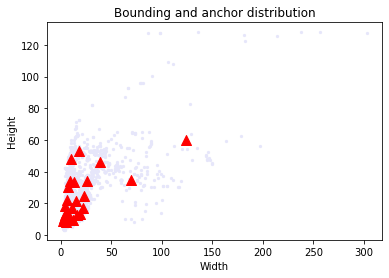

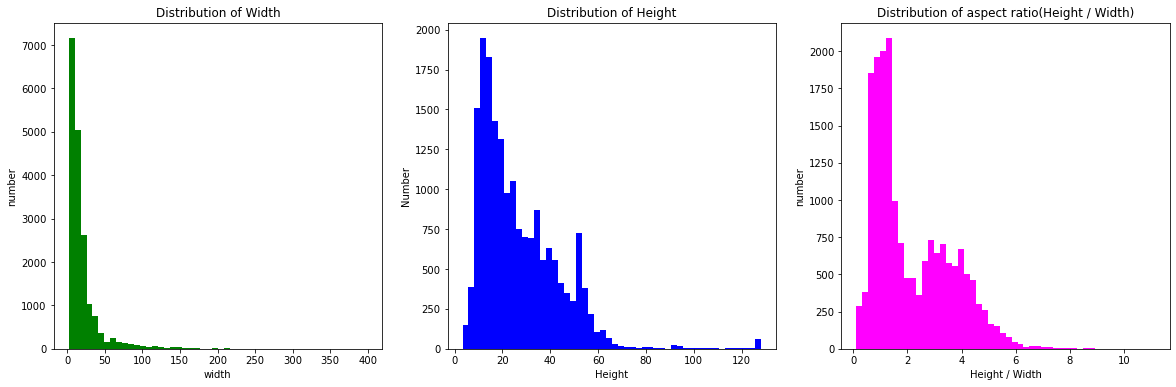

Recommended aspect ratios: (width/height)
 width     height     ratio     count
 39.32     46.20      1.17    2087.00
  9.68     11.00      1.14    2087.00
 22.81     24.99      1.10    2087.00
 12.72      9.85      0.77    2003.00
 16.00     12.95      0.81    2003.00
 22.63     17.10      0.76    1961.00
 19.09     13.41      0.70    1961.00
124.47     60.21      0.48    1856.00
 69.92     34.91      0.50    1856.00
  5.85      8.31      1.42    992.00
 15.43     21.57      1.40    992.00
 26.00     33.95      1.31    992.00
  5.41     14.23      2.63    729.00
 11.76     17.33      1.47    711.00
  4.18     12.75      3.05    706.00
  8.95     33.95      3.79    671.00
  2.36      8.81      3.73    671.00
 18.00     52.85      2.94    647.00
 13.44     33.31      2.48    592.00
  3.29     11.08      3.37    576.00
  6.51     22.08      3.39    576.00
  4.66     18.56      3.98    505.00
  6.81     13.01      1.91    473.00
  7.09     30.68      4.33    298.00
 10.70     48.26      4

In [67]:
# Import kmeans
from dataset_exploration.kmeans import run_kmeans

n_clusters = 25

acc, out_sorted = run_kmeans(bboxes, n_clusters, bins=50, sort='frequency', verbose=True)

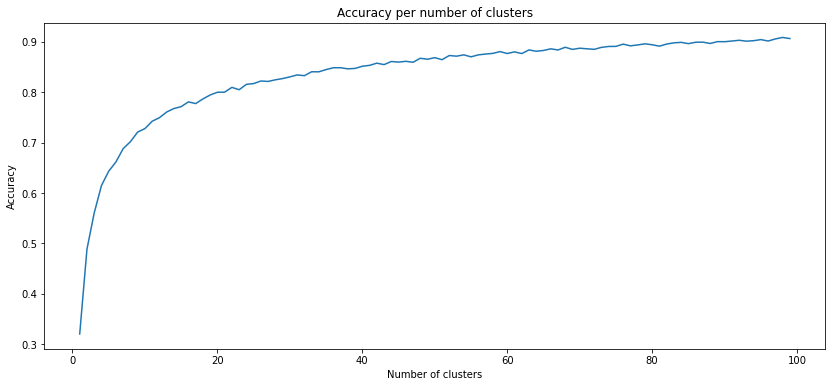

In [43]:
# Plot accuracy per cluster size
plt.figure(figsize=(14, 6))
plt.plot(cluster_size, accuracies)
plt.xlabel("Number of clusters")
plt.ylabel("Accuracy")
plt.title("Accuracy per number of clusters")
plt.show()